In [2]:
from scipy.fftpack import fft, ifft, fftshift
from scipy import conj, linspace, exp
from scipy.constants import pi
from matplotlib import pyplot as plt
import numpy as np
from numpy import zeros, sqrt, conj

from scipy.constants import pi, c
import torch


In [3]:
def generate_lfm(bandwidth,pulse_duration,fs,total_duration):
    pulse_num_samples = int(np.ceil(pulse_duration * fs))
    t = torch.linspace(0, pulse_duration, pulse_num_samples)
    
    k = bandwidth/pulse_duration
    
    lfm = torch.exp(1j * pi * k * (t-pulse_duration/2)**2);
    signal = torch.zeros((pulse_num_samples,), dtype=torch.complex64)
    signal[:len(lfm)] = lfm
    return  signal

In [4]:
def simulate_scene(signal,  num_pulses, amplitudes, ranges, velocities, u_range, u_vel, nfft_range, nfft_doppler):
    # compute normalized aparent ranges and velocities (considering ambiguos range/vel)
    # why do we normalize? 
    ranges = torch.fmod(ranges, u_range) / u_range 
    velocities = torch.fmod(velocities, u_vel) / u_vel

    # compute binnned range and velocities
    ranges = torch.round((ranges  + 1) * (nfft_range//2)).long()
    velocities = torch.round((velocities + 1) * (nfft_doppler//2)).long()

    # fill scene matrix
    scene = torch.zeros(1,nfft_doppler,nfft_range,dtype=torch.complex64)
    for i,(rind,vind) in enumerate(zip(ranges,velocities)):
        scene[0,vind,rind] = amplitudes[i]
      
    # scaling for correcting signal amplitude
    
    range_fft_scaling = torch.sqrt(torch.Tensor([nfft_range]))
    doppler_fft_scaling = torch.sqrt(torch.Tensor([nfft_doppler]))
    
    # kernel from operation
    kernel = fft(signal, nfft=nfft_range)
    
    # arrange Doppler bins
    scene_profile = torch.fft.fftshift(torch.fft.fftshift(scene,dim=-2),dim=-1)
    print(scene_profile.shape)
    
    # This step is completely opaque to me
    # propagate dopplers from targets and select the number of pulses
    scene_profile = ifft(scene_profile,nfft=nfft_doppler,dim=-2)[:,:num_pulses,:] * doppler_fft_scaling
    print(scene_profile.shape)
    # compute fft of the range profiles of each of the pulses
    scene_profile = fft(scene_profile,nfft=nfft_range,dim=-1) * range_fft_scaling
    
    # apply convolution with signal kernel and go back to time domain
    scene_profile = ifft(torch.multiply(kernel,scene_profile),nfft=nfft_range,dim=-1)
    return scene_profile

def fft(signal, nfft :int=None,dim :int=-1):
    data = signal.data
    nfft = nfft if nfft else 2 * num_samples - 1
    return torch.fft.fft(input=data,n=nfft,dim=dim,norm='ortho')

def ifft(signal,nfft :int=None,dim :int=-1):
    data = signal.data
    nfft = nfft if nfft else 2*num_samples - 1
    return torch.fft.ifft(input=data,n=nfft,dim=dim,norm='ortho')


In [5]:
def doppler_processing(cube, nfft_range, nfft_doppler):
    # FFT of signal
    kernel = torch.conj(fft(cube,nfft=nfft_range))
    
    doppler_window = torch.ones(cube.shape[-2])
    
    doppler_fft_scaling = torch.Tensor([cube.shape[-2]])
    
    PC = torch.sqrt(torch.Tensor([nfft_range])) * \
            ifft(torch.multiply(kernel,fft(cube,nfft=nfft_range,dim=-1)),nfft=nfft_range,dim=-1)
    print(PC.shape)
    PC = torch.multiply(doppler_window.view(1,-1,1),PC)
    print(PC.shape)
    RD = fft(PC,nfft=nfft_doppler,dim=-2) * doppler_fft_scaling

    return RD

In [6]:
bandwidth = 10e6
pulse_duration = 10e-6
total_duration = 2e-4
fs = 4 * bandwidth
num_samples = int(np.ceil(pulse_duration * fs))

lfm = generate_lfm(
    bandwidth=bandwidth,
    pulse_duration=pulse_duration,
    fs = 4*bandwidth,
    total_duration=total_duration,)

fc = 1e9
max_unamb_range = c * (total_duration - pulse_duration)/2
max_unamb_vel = c/(4*fc*total_duration)

nfft_range = 2*int(np.ceil(total_duration * fs)) - 1
nfft_doppler = 1024

torch.Size([1, 1024, 15999])
torch.Size([1, 32, 15999])


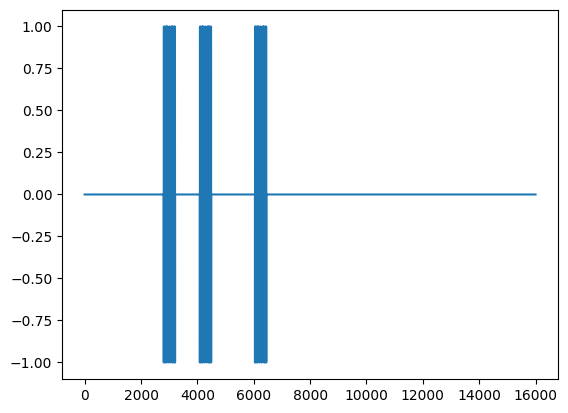

In [7]:
num_pulses = 32
received_signal = simulate_scene(
        signal=lfm,
        num_pulses=num_pulses,
        amplitudes=torch.Tensor([1.0,1.0,1.0]),
        ranges=torch.Tensor([10e3,50e3,100e3]),
        velocities=torch.Tensor([20,-250,675]),
        u_range=max_unamb_range,
        u_vel=max_unamb_vel,
        nfft_range=nfft_range,
        nfft_doppler=nfft_doppler)

plt.plot(torch.real(received_signal[0,0,:]))
plt.show()

torch.Size([1, 32, 15999])
torch.Size([1, 32, 15999])
torch.Size([1, 1024, 15999])
SNR Loss: 9.54241943359375 dB


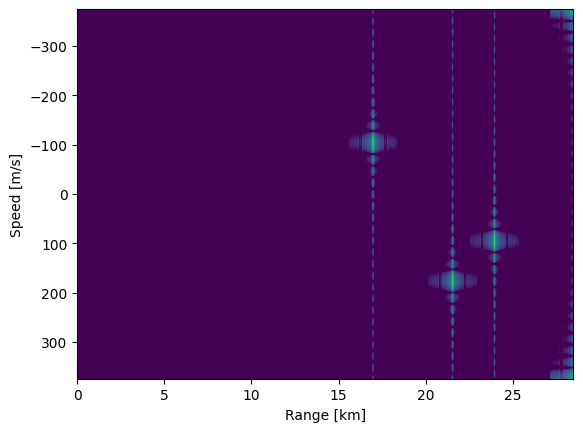

In [9]:
coherent_gain = int(np.ceil(pulse_duration * fs)) * received_signal.shape[-2]

coherent_gain_db =  20*torch.log10(torch.Tensor([coherent_gain]))

RDout = 20 * torch.log10(1E-16 + torch.abs(doppler_processing(received_signal, nfft_range, nfft_doppler)))
RDout =  RDout - coherent_gain_db
print(f'SNR Loss: {torch.max(RDout)} dB')
plt.imshow(RDout[0,:,nfft_range//2:].cpu(),aspect='auto',extent=[0,max_unamb_range*1E-3,max_unamb_vel,-max_unamb_vel])
plt.xlabel('Range [km]')
plt.ylabel('Speed [m/s]')
plt.clim(-60,0)